In [1]:
import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])
mnist_dataset = torchvision.datasets.MNIST(root='./', train=True, transform=transform, download=True)
example, label = next(iter(mnist_dataset))

example.min(), example.max(), example.shape

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.30MB/s]


(tensor(-1.), tensor(1.), torch.Size([1, 28, 28]))

In [3]:
batch_size = 64
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters * 4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_filters * 4),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters * 4, n_filters * 2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters * 2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters * 2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    return model

In [5]:
class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters, n_filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters * 2, n_filters * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [6]:
z_size = 100
image_size = (28, 28)
n_filters = 32

device = torch.device('cuda:0')
gen_model = make_generator_network(z_size, n_filters).to(device)
gen_model

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)

In [7]:
disc_model = Discriminator(n_filters).to(device)
disc_model

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [8]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [9]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1) * 2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [10]:
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images + 1) / 2.0

In [11]:
mode_z = 'uniform'

def d_train(x):
    disc_model.zero_grad()
    batch_size = x.size(0)

    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [12]:
def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)

    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [13]:
num_epochs = 100
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
epoch_samples = []
for epoch in range(1, num_epochs + 1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

    print(f'Epoch {epoch} | Avd Lossed >> G/D {torch.FloatTensor(g_losses).mean()} / {torch.FloatTensor(d_losses).mean()}')
    gen_model.eval()
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 1 | Avd Lossed >> G/D 4.448829174041748 / 0.1286444216966629
Epoch 2 | Avd Lossed >> G/D 4.625516414642334 / 0.14125286042690277
Epoch 3 | Avd Lossed >> G/D 3.9113948345184326 / 0.24161922931671143
Epoch 4 | Avd Lossed >> G/D 3.1427111625671387 / 0.35699158906936646
Epoch 5 | Avd Lossed >> G/D 2.8267202377319336 / 0.3685392737388611
Epoch 6 | Avd Lossed >> G/D 2.8933701515197754 / 0.3403307795524597
Epoch 7 | Avd Lossed >> G/D 2.9128518104553223 / 0.3506496250629425
Epoch 8 | Avd Lossed >> G/D 2.9417850971221924 / 0.3144649267196655
Epoch 9 | Avd Lossed >> G/D 3.0081777572631836 / 0.3121866285800934
Epoch 10 | Avd Lossed >> G/D 3.023369073867798 / 0.2906816005706787
Epoch 11 | Avd Lossed >> G/D 3.144050121307373 / 0.2697933614253998
Epoch 12 | Avd Lossed >> G/D 3.229605197906494 / 0.25817158818244934
Epoch 13 | Avd Lossed >> G/D 3.3087475299835205 / 0.24400362372398376
Epoch 14 | Avd Lossed >> G/D 3.344531774520874 / 0.2409793883562088
Epoch 15 | Avd Lossed >> G/D 3.4507062435150

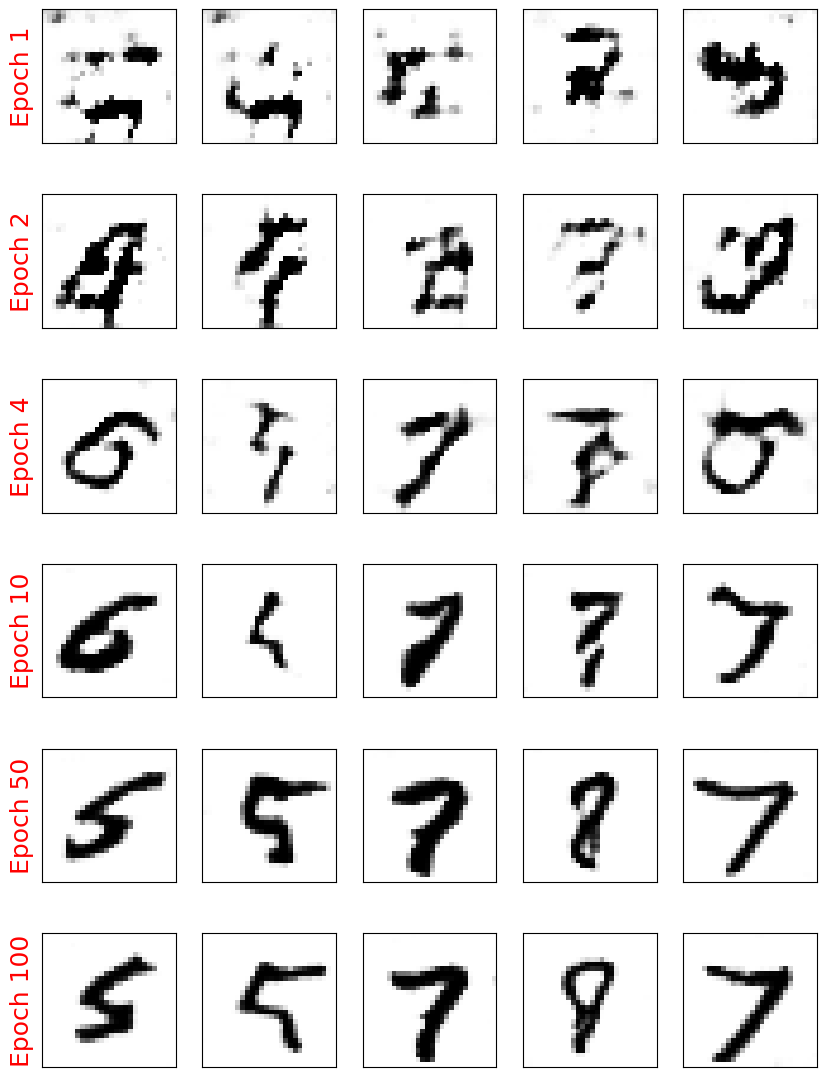

In [14]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(-0.06, 0.5, f'Epoch {e}', rotation=90, size=18, color='red', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

In [15]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters * 4, 4, 1, 0, bias=False),
        nn.InstanceNorm2d(n_filters * 4),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters * 4, n_filters * 2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters * 2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters * 2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    return model

In [16]:
class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters, n_filters * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters * 2, n_filters * 4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [17]:
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [23]:
from torch.autograd import grad as torch_grad
lambda_gp = 10.0

def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    proba_interpolated = disc_model(interpolated)
    gradients = torch_grad(outputs=proba_interpolated,
                           inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True,
                           retain_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1) ** 2).mean()

In [21]:
def d_train_wgan(x):
    disc_model.zero_grad()
    batch_size = x.size(0)
    x = x.to(device)
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item()

def g_train_wgan(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    g_loss = - d_generated.mean()
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.item()

In [25]:
epoch_samples_wgan = []
num_epochs = 100
critic_iterations = 5
for epoch in range(1, num_epochs + 1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations):
            d_loss = d_train_wgan(x)
            d_losses.append(d_loss)
            g_losses.append(g_train_wgan(x))
    print(f'Epoch {epoch} | D Loss >> {torch.FloatTensor(d_losses).mean()}')
    gen_model.eval()
    epoch_samples_wgan.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 1 | D Loss >> -0.3677544593811035
Epoch 2 | D Loss >> -0.3151967525482178
Epoch 3 | D Loss >> -0.2849689722061157
Epoch 4 | D Loss >> -0.2670101523399353
Epoch 5 | D Loss >> -0.26060953736305237
Epoch 6 | D Loss >> -0.2568483352661133
Epoch 7 | D Loss >> -0.25335636734962463
Epoch 8 | D Loss >> -0.2524724006652832
Epoch 9 | D Loss >> -0.25163543224334717
Epoch 10 | D Loss >> -0.24871759116649628
Epoch 11 | D Loss >> -0.25086432695388794
Epoch 12 | D Loss >> -0.25388047099113464
Epoch 13 | D Loss >> -0.25439995527267456
Epoch 14 | D Loss >> -0.25699570775032043
Epoch 15 | D Loss >> -0.25859662890434265
Epoch 16 | D Loss >> -0.26354482769966125
Epoch 17 | D Loss >> -0.26467227935791016
Epoch 18 | D Loss >> -0.2687353789806366
Epoch 19 | D Loss >> -0.271525114774704
Epoch 20 | D Loss >> -0.27718961238861084
Epoch 21 | D Loss >> -0.27742713689804077
Epoch 22 | D Loss >> -0.28031378984451294
Epoch 23 | D Loss >> -0.2829493582248688
Epoch 24 | D Loss >> -0.286488801240921
Epoch 25 | D 

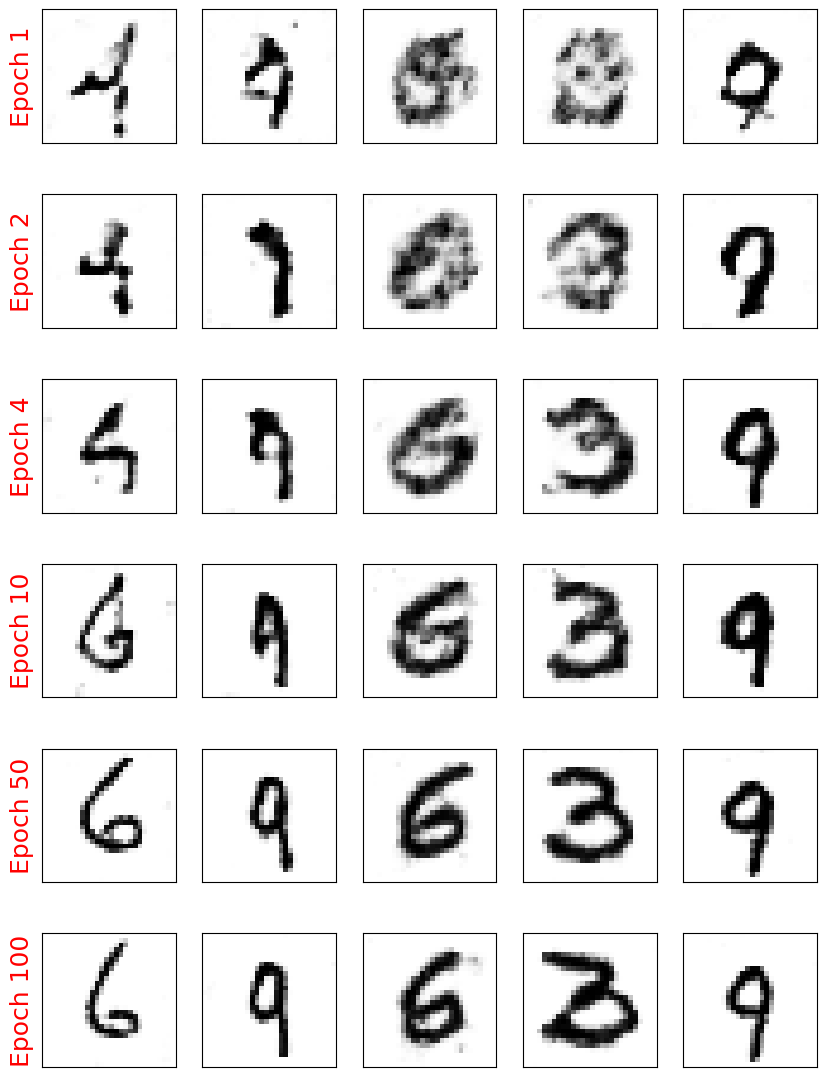

In [26]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(-0.06, 0.5, f'Epoch {e}', rotation=90, size=18, color='red', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')